In [4]:
%load_ext autoreload
%autoreload 2

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Plotting helper functions

In [889]:
def plot_miscoverage_examples(test_dataset, coverages, intervals):
    miscovered_idx = torch.nonzero(~coverages, as_tuple=False)[:, 0].tolist()
    fig, axs = plt.subplots(5, 2, figsize=(10, 10), sharey=True)

    for ax in axs.flat:
        i = np.random.choice(miscovered_idx)
        ax.fill_between(range(test_dataset[i][1].size(0)),
                         intervals[i, 0].flatten().tolist(), 
                         intervals[i, 1].flatten().tolist(), 
                         color="r", alpha=0.25)
        ax.plot(intervals[i, 0].flatten().tolist(), linestyle="--", color="r")
        ax.plot(intervals[i, 1].flatten().tolist(), linestyle="--", color="r")
        ax.plot((intervals[i, 0] + (intervals[i, 1] - intervals[i, 0]) / 2).flatten().tolist(), linestyle="--", linewidth=3, color="r")

        ax.scatter(range(test_dataset[i][1].size(0)), test_dataset[i][1].flatten().tolist(), color="black")

        ax.set(xlabel='Time step', ylabel='Prediction')
    plt.show()
    
def plot_ts(dataset, coverages, intervals, idx=None, forecast_only=False):
    fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 8), sharex=True)
    
    if idx is None:
        idx = range(len(dataset))

    for ax in axs.flat:
        i = np.random.choice(idx)
        
        # Derive unpadded sequences and targets
        sequence, target, length = dataset[i]
        
        horizon = min(len(target), length)
        sequence, target = sequence[:length].flatten().tolist(), target[:horizon].flatten().tolist()
        
        if not forecast_only:
            # (Scatter)plot of the time series
            ax.plot(range(1, length+1), sequence, color="black")
            
            # Prediction start vertical
            ax.axvline(length, linestyle="--", color="black")
        
        ax.scatter(range(length + 1, length + horizon + 1), target, color="black")
        
        # Interval boundaries
        lower = [sequence[-1]] + intervals[i, 0].flatten().tolist()[:horizon]
        upper = [sequence[-1]] + intervals[i, 1].flatten().tolist()[:horizon]
        pred = [sequence[-1]] + (intervals[i, 0] + (intervals[i, 1] - intervals[i, 0]) / 2).flatten().tolist()[:horizon]
        
        ax.fill_between(range(length, length + horizon + 1), lower, upper, color="r", alpha=0.25)
        ax.plot(range(length, length + horizon + 1), lower, linestyle="--", color="r")
        ax.plot(range(length, length + horizon + 1), upper, linestyle="--", color="r")
        ax.plot(range(length, length + horizon + 1), pred, linestyle="--", linewidth=3, color="r")

        ax.set(ylabel='Prediction')
    
    plt.xlabel('Time step')
    #     plt.ylabel('Prediction')
    plt.show()

## Hyperparameters

In [963]:
# Dataset size
n_train_samples = 1000
n_calibration_samples = 1000
n_test_samples = 500

# Time series parameters
seq_len = 10
horizon = 5
noise_profile = [0.1 * k for k in range(seq_len + horizon)]
periodicity = 2
amplitude = 1
dynamic_sequence_lengths=False

# LSTM parameters
epochs=1000
batch_size=100
embedding_size=20
coverage=0.9
lr=0.01

## Generate datasets

In [964]:
from utils.make_data import generate_autoregressive_forecast_dataset
train_dataset = generate_autoregressive_forecast_dataset(n_samples=n_train_samples, 
                                                               seq_len=seq_len, 
                                                               horizon=horizon, 
                                                               periodicity=periodicity,
                                                               noise_profile=noise_profile, 
                                                               amplitude=amplitude,
                                                               dynamic_sequence_lengths=dynamic_sequence_lengths)
calibration_dataset = generate_autoregressive_forecast_dataset(n_samples=n_calibration_samples, 
                                                               seq_len=seq_len, 
                                                               horizon=horizon, 
                                                               periodicity=periodicity,
                                                               noise_profile=noise_profile, 
                                                               amplitude=amplitude,
                                                               dynamic_sequence_lengths=dynamic_sequence_lengths)
test_dataset = generate_autoregressive_forecast_dataset(n_samples=n_test_samples, 
                                                               seq_len=seq_len, 
                                                               horizon=horizon, 
                                                               periodicity=periodicity,
                                                               noise_profile=noise_profile, 
                                                               amplitude=amplitude,
                                                               dynamic_sequence_lengths=dynamic_sequence_lengths)

## Conformal forecaster

In [965]:
from models.conformal import ConformalForecaster
model = ConformalForecaster(embedding_size=embedding_size, horizon=horizon, error_rate=1-coverage)

In [966]:
model.fit(train_dataset, calibration_dataset, epochs=epochs, lr=lr, batch_size=batch_size)

Epoch: 0	Train loss: 90.03600997924805
Epoch: 50	Train loss: 16.06012830734253
Epoch: 100	Train loss: 13.419668865203857
Epoch: 150	Train loss: 12.036290264129638
Epoch: 200	Train loss: 10.706856536865235
Epoch: 250	Train loss: 9.539083862304688
Epoch: 300	Train loss: 8.627713441848755
Epoch: 350	Train loss: 8.575873565673827
Epoch: 400	Train loss: 8.18711452484131
Epoch: 450	Train loss: 7.170155477523804
Epoch: 500	Train loss: 7.597601652145386
Epoch: 550	Train loss: 8.1293475151062
Epoch: 600	Train loss: 6.668988990783691
Epoch: 650	Train loss: 6.817715740203857
Epoch: 700	Train loss: 6.375599479675293
Epoch: 750	Train loss: 6.400059652328491
Epoch: 800	Train loss: 6.817319059371949
Epoch: 850	Train loss: 7.949629306793213
Epoch: 900	Train loss: 6.128638410568238
Epoch: 950	Train loss: 6.272935771942139


## Coverage evaluation

In [967]:
coverages, intervals = model.evaluate_coverage(test_dataset)
print('% of series within predicted intervals: {}'.format(torch.mean(coverages.float(), dim=0).item()))

% of series within predicted intervals: 0.9200000166893005


## Plotting

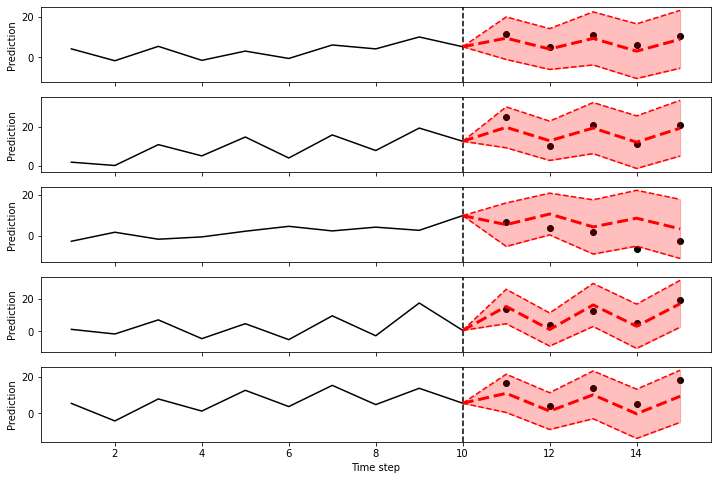

In [968]:
plot_ts(test_dataset, coverages, intervals)

Interval widths:

In [974]:
(intervals[:, 1] - intervals[:, 0]).squeeze().mean(dim=0)

tensor([21.1656, 20.3236, 26.4157, 27.2050, 28.7967], grad_fn=<MeanBackward1>)

In [976]:
(intervals[:, 1] - intervals[:, 0]).squeeze().mean()

tensor(24.7813, grad_fn=<MeanBackward0>)

In comparison with BJ-RNN on the same dataset and parameters (with the underlying RNN achieving the same training loss), Conformal forecaster:
* was significantly, incomparatively faster
* while it has lower empirical coverage (92% vs 100%) it is still at the sufficient level satisfying the theoretical guarantees
* has much smaller interval widths (24.7813 vs 231.94795306396472)


## Collecting all data